## Spark Dataframes Tutorial 

Let's setup Spark on your Colab environment.  Run the cell below!

In [31]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://apache.mirror.colo-serv.net/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init("spark-2.4.7-bin-hadoop2.7")# SPARK_HOME

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
sp500 = spark.read.csv("/content/drive/MyDrive/sp500.csv", header=True)
history = spark.read.csv("/content/drive/MyDrive/history.csv", header=True)

Check the schema:

In [9]:
sp500.printSchema()
history.printSchema()

root
 |-- Symbol: string (nullable = true)
 |-- Security: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- SubIndustry: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- State: string (nullable = true)

root
 |-- symbol: string (nullable = true)
 |-- day: string (nullable = true)
 |-- open: string (nullable = true)
 |-- high: string (nullable = true)
 |-- low: string (nullable = true)
 |-- close: string (nullable = true)
 |-- volume: string (nullable = true)
 |-- adjclose: string (nullable = true)



Get a sample with `take()`:

In [10]:
sp500.take(3)

[Row(Symbol='A', Security='Agilent Technologies Inc', Sector='Health Care', SubIndustry='Health Care Equipment & Services', Address='Santa Clara', State='California'),
 Row(Symbol='AA', Security='Alcoa Inc', Sector='Materials', SubIndustry='Aluminum', Address='New York', State='New York'),
 Row(Symbol='AAL', Security='American Airlines Group', Sector='Industrials', SubIndustry='Airlines', Address='Fort Worth', State='Texas')]

Get a formatted sample with `show()`:

In [11]:
sp500.show()

+------+--------------------+--------------------+--------------------+-------------+-------------+
|Symbol|            Security|              Sector|         SubIndustry|      Address|        State|
+------+--------------------+--------------------+--------------------+-------------+-------------+
|     A|Agilent Technolog...|         Health Care|Health Care Equip...|  Santa Clara|   California|
|    AA|           Alcoa Inc|           Materials|            Aluminum|     New York|     New York|
|   AAL|American Airlines...|         Industrials|            Airlines|   Fort Worth|        Texas|
|   AAP|  Advance Auto Parts|Consumer Discreti...|   Automotive Retail|      Roanoke|     Virginia|
|  AAPL|          Apple Inc.|Information Techn...|   Computer Hardware|    Cupertino|   California|
|  ABBV|              AbbVie|         Health Care|     Pharmaceuticals|North Chicago|     Illinois|
|   ABC|AmerisourceBergen...|         Health Care|Health Care Distr...| Chesterbrook| Pennsylvania|


In [13]:
history.show()

+------+----------+-----+-----+-----+-----+-------+--------+
|symbol|       day| open| high|  low|close| volume|adjclose|
+------+----------+-----+-----+-----+-----+-------+--------+
|     A|2015-11-13|37.39|37.57|36.63|36.77|3081000|   36.77|
|     A|2015-11-12|37.36|37.77|37.24|37.49|3053000|   37.49|
|     A|2015-11-11|38.16|38.22|37.65|37.66|1967900|   37.66|
|     A|2015-11-10|37.89|38.17|37.69|37.98|4338700|   37.98|
|     A|2015-11-09|38.04|38.08|37.48|37.92|3107100|   37.92|
|     A|2015-11-06| 38.1|38.44|37.98|38.14|1964100|   38.14|
|     A|2015-11-05|38.27| 38.5|37.93| 38.3|1419800|    38.3|
|     A|2015-11-04|38.33|38.48|   38|38.34|1569600|   38.34|
|     A|2015-11-03|38.31|38.52|38.16|38.27|1485800|   38.27|
|     A|2015-11-02|37.87|38.62| 37.8|38.59|1810800|   38.59|
|     A|2015-10-30|37.72| 38.1|37.68|37.76|2191900|   37.76|
|     A|2015-10-29|37.47|37.77|37.28| 37.7|1337800|    37.7|
|     A|2015-10-28|37.06|37.61|36.77|37.52|1780100|   37.52|
|     A|2015-10-27|36.67

In [26]:
print("In total there are {0} companies".format(sp500.count()))

In total there are 505 companies


In [34]:
# How many companies are there for each sector? Sort descending. 

sector_counts = sp500.groupBy("Sector")\
                     .agg(count("Symbol")\
                     .alias("cnt"))\
                     .sort(desc("cnt"))

sector_counts.show()

+--------------------+---+
|              Sector|cnt|
+--------------------+---+
|Consumer Discreti...| 87|
|          Financials| 87|
|Information Techn...| 69|
|         Industrials| 68|
|         Health Care| 56|
|              Energy| 40|
|    Consumer Staples| 37|
|           Utilities| 29|
|           Materials| 27|
|Telecommunication...|  5|
+--------------------+---+



In [41]:
# What was the dollar volume for each sector on the first business day of 2015?

'''
select s.sector, round(sum(adjclose*volume)) as dollarvol
from history h JOIN sp500 s on h.symbol = s.Symbol
where h.day = '2015-01-02'
group by s.Sector
order by dollarvol desc;
'''

result = history.join(sp500, on=['Symbol'])\
                .where(col('day')=='2015-01-02')\
                .groupBy('Sector')\
                .agg(round(sum(col('adjclose')*col('volume'))).alias('dollarvol'))\
                .sort(desc('dollarvol'))

result.show()

+--------------------+---------------+
|              Sector|      dollarvol|
+--------------------+---------------+
|Information Techn...|   2.0809525E10|
|Consumer Discreti...|1.3220064437E10|
|          Financials|1.1222214125E10|
|         Health Care|  1.07161041E10|
|         Industrials|1.0156687427E10|
|              Energy|  8.877061817E9|
|    Consumer Staples|  6.130142919E9|
|           Materials|  3.153829898E9|
|           Utilities|  2.999714128E9|
|Telecommunication...|  1.351960029E9|
+--------------------+---------------+



In this case we used the DataFrame API, but we could rewrite the expression using pure SQL:

In [43]:
sp500.registerTempTable('sp500')
history.registerTempTable('history')

query = """
select s.sector, round(sum(adjclose*volume)) as dollarvol
from history h JOIN sp500 s on h.symbol = s.Symbol
where h.day = '2015-01-02'
group by s.Sector
order by dollarvol desc
"""

result = spark.sql(query)
result.show()

+--------------------+---------------+
|              sector|      dollarvol|
+--------------------+---------------+
|Information Techn...|   2.0809525E10|
|Consumer Discreti...|1.3220064437E10|
|          Financials|1.1222214125E10|
|         Health Care|  1.07161041E10|
|         Industrials|1.0156687427E10|
|              Energy|  8.877061817E9|
|    Consumer Staples|  6.130142919E9|
|           Materials|  3.153829898E9|
|           Utilities|  2.999714128E9|
|Telecommunication...|  1.351960029E9|
+--------------------+---------------+



The Dataframe is small enough to be moved to Pandas:

In [44]:
result_pd = result.toPandas()
result_pd.head()

,sector,dollarvol
0,Information Technology,2.080952e+10
1,Consumer Discretionary,1.322006e+10
2,Financials,1.122221e+10
3,Health Care,1.071610e+10
4,Industrials,1.015669e+10


Let's plot a barchart with the number of missions by country:

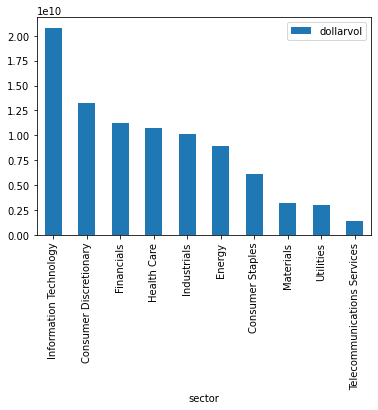

In [47]:
result_pd.plot(kind="bar", x="sector", y="dollarvol")

----

Using RDDs

In [49]:
# Let's consider again the sector count query

sector_counts = sp500.groupBy("Sector")\
                     .agg(count("Symbol")\
                     .alias("cnt"))\
                     .sort(desc("cnt"))

sector_counts.show()

+--------------------+---+
|              Sector|cnt|
+--------------------+---+
|          Financials| 87|
|Consumer Discreti...| 87|
|Information Techn...| 69|
|         Industrials| 68|
|         Health Care| 56|
|              Energy| 40|
|    Consumer Staples| 37|
|           Utilities| 29|
|           Materials| 27|
|Telecommunication...|  5|
+--------------------+---+



In [62]:
sectors_rdd = sp500.rdd.map(lambda row: (row.Sector, 1))
sectors_rdd.take(20)

[('Health Care', 1),
 ('Materials', 1),
 ('Industrials', 1),
 ('Consumer Discretionary', 1),
 ('Information Technology', 1),
 ('Health Care', 1),
 ('Health Care', 1),
 ('Health Care', 1),
 ('Financials', 1),
 ('Information Technology', 1),
 ('Information Technology', 1),
 ('Information Technology', 1),
 ('Consumer Staples', 1),
 ('Information Technology', 1),
 ('Information Technology', 1),
 ('Information Technology', 1),
 ('Industrials', 1),
 ('Utilities', 1),
 ('Utilities', 1),
 ('Utilities', 1)]

Then, we sum counters in the reduce step, and we sort by count:

In [63]:
sector_counts_rdd = sectors_rdd.reduceByKey(lambda a, b: a+b).sortBy(lambda r: -r[1])
sector_counts_rdd.collect()

[('Consumer Discretionary', 87),
 ('Financials', 87),
 ('Information Technology', 69),
 ('Industrials', 68),
 ('Health Care', 56),
 ('Energy', 40),
 ('Consumer Staples', 37),
 ('Utilities', 29),
 ('Materials', 27),
 ('Telecommunications Services', 5)]

Now we can convert the RDD in dataframe by mapping the pairs to objects of type `Row`

In [64]:
sector_counts_with_schema = sector_counts_rdd.map(lambda r: Row(Sector=r[0], Count=r[1]))
sector_counts_df = spark.createDataFrame(sector_counts_with_schema)
sector_counts_df.show()

+-----+--------------------+
|Count|              Sector|
+-----+--------------------+
|   87|Consumer Discreti...|
|   87|          Financials|
|   69|Information Techn...|
|   68|         Industrials|
|   56|         Health Care|
|   40|              Energy|
|   37|    Consumer Staples|
|   29|           Utilities|
|   27|           Materials|
|    5|Telecommunication...|
+-----+--------------------+

